In [1]:
import json
import pandas as pd

ratings = []
repos = []
teams = set()
repo_teams = {}
with open('repo_profiles_new.json') as rj:
    for rl in rj.readlines():
        line = rl.split('\t')
        repo = line[0]
        profile = json.loads(line[1])
        repos.append(repo)
        teams.update(profile['teams'])
        repo_teams[repo] = set(profile['teams'])
        for team in profile['teams']:
            ratings.append([repo,team,1])

In [2]:
from surprise import Reader, SVD, Dataset, accuracy
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(0,1))
dataset = Dataset.load_from_df(pd.DataFrame(ratings),reader)
trainset, testset = train_test_split(dataset, test_size=.25)

In [3]:
algo = SVD()

predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.0625


0.06251704701003759

In [4]:
from queue import PriorityQueue

full_data = dataset.build_full_trainset()
algo.fit(full_data)

team_recommendations = []
cnt = 0
for repo in repos:
    cnt += 1
    if cnt > 1:
        break
    print(cnt)
    rec = []
    queue = PriorityQueue()
    min_p = 1
    for team in teams:
        if team in repo_teams[repo]:
            continue
        p = algo.predict(repo,team)
        if p[3] < min_p:
            print(p)
            min_p = p[3]
        queue.put_nowait((p[3],team))
        if queue.qsize() > 50:
            queue.get_nowait()
    while queue.qsize()>0:
        rec.append(queue.get_nowait())
    team_recommendations.append(rec)

1
user: Starbound-Dev/starbound-dev item: ["pgrm", "lgrignon", "optical", "horiuchi", "xt0rted", "cyrilschumacher", "nalbion", "darkl", "mkozhukh", "mzsm", "zlumer", "vangorra", "phillips1012", "dreampulse", "borislavjivkov", "outring", "marcinporebski", "flyfishMT", "joewashear007", "JacobDanton", "DeadAlready", "kwiateusz", "damianog", "eirikhm", "rdennis", "hellopao", "gandjustas", "arma-gast", "frankbille", "dalie", "kwilson", "leonardochaia", "woutergd", "luzianz", "andrewarchi", "stpettersens", "divillysausages", "igochkov", "gjunge", "MrHen", "Justin-Credible", "RWander", "benzid-wael", "DeividasBakanas", "oizie", "mmckenziedev", "danny8002"] r_ui = None   est = 1.00   {'was_impossible': False}
user: Starbound-Dev/starbound-dev item: ["m-vo", "MDevster"] r_ui = None   est = 0.99   {'was_impossible': False}
user: Starbound-Dev/starbound-dev item: ["strugee", "Hainish", "cowlicks", "sinak", "wioux", "codec", "vbrown608", "TheNotary", "gcosta", "JanKoppe", "matzegebbe", "Bisaloo", 

In [5]:
for i,rec in enumerate(team_recommendations):
    print(repos[i])
    for tm in rec:
        print(json.dumps(list(tm)))

Starbound-Dev/starbound-dev
[1, "[\"zenangst\", \"bcylin\", \"chendo\", \"dev4dev\", \"jawwad\", \"bmnick\", \"JARMourato\", \"goktugyil\", \"bahlo\", \"poboke\", \"kumapo\", \"r-mckay\", \"Yu-w\"]"]
[1, "[\"zenorocha\", \"fsbatista\", \"SauloSilva\", \"rands0n\", \"heinst\", \"dsifford\", \"Ulthes\", \"epidemicz\"]"]
[1, "[\"zeppelin\", \"tonywok\", \"pootsbook\", \"quaertym\", \"digitaltoad\", \"FelixAkk\"]"]
[1, "[\"zerok\", \"codersquid\", \"lorenanicole\", \"justmarkham\", \"paulcollinsiii\", \"logston\", \"mattboehm\", \"cldershem\", \"mikeckennedy\", \"elzilrac\", \"tfors\", \"Dinkins\", \"b-jazz\", \"smarlowucf\", \"ivan-bilan\"]"]
[1, "[\"zerok\", \"willkg\", \"codersquid\", \"redapple\", \"mattboehm\", \"dhoffman34\", \"Daniel-at-github\", \"lgh2\"]"]
[1, "[\"zerolab\", \"coredumperror\", \"timheap\", \"mhindery\", \"jimr\", \"chrxr\", \"SableWalnut\", \"m1kola\", \"nfletton\", \"benebun\", \"AdamBolfik\"]"]
[1, "[\"zfkang-talend\", \"pbabin\", \"sbliu\"]"]
[1, "[\"zflamig\",

In [6]:
import numpy as np
from matplotlib import pyplot as plt

def NDCG(repo,rec,team_target):
    dcg = 0
    for i,tm in enumerate(rec):
        if tm in team_target and repo == team_target[tm]:
            dcg += 1/np.log2(i+2)
    target_cnt = 0
    idcg =  0
    for tm in team_target:
        target = team_target[tm]
        if target == repo:
            target_cnt += 1
            idcg += 1/np.log2(target_cnt+1)
    dcg /= idcg
    return dcg

recommendations = {}
with open('recommend_svd.json') as rj:
    for l in rj.readlines():
        line = l.strip().split('\t')
        repo = line[0]
        recs = [json.loads(t)[1] for t in line[1:]]
        recommendations[repo] = recs[::-1]
team_target = {}
with open('team_profiles.json') as tj:
    for tl in tj.readlines():
        line = tl.split('\t')
        team = line[0]
        profile = json.loads(line[1])
        team_target[team] = profile['target']

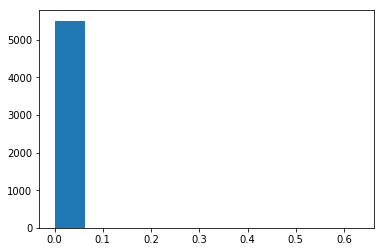

In [7]:
NDCGs = []
for repo in recommendations:
    NDCGs.append(NDCG(repo,recommendations[repo],team_target))
plt.hist(NDCGs)
plt.show()